In [1]:
# %pip install numpy matplotlib scipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft

In [3]:
# normalization from -1 to 1
def normalize_signal(signal):
    signal_copy = signal.copy()
    signal_copy = signal_copy.astype(float)
    min_val = np.min(signal_copy)
    max_val = np.max(signal_copy)
    normalized_signal = 2 * (signal_copy - min_val) / (max_val - min_val) - 1
    return normalized_signal

# function to compute Shannon Energy Envelope
def see(signal, window_size):
    signal_copy = signal.copy()
    signal_copy = signal_copy.astype(float)
    # Compute the squared signal
    squared_signal = signal_copy ** 2
    # Compute the Shannon energy
    shannon_energy = -squared_signal * np.log(squared_signal + 1e-10)  # Adding a small constant to avoid log(0)
    # Smooth the Shannon energy using a moving average filter
    edges = int(window_size // 2)
    start = edges
    end = len(squared_signal) - edges
    envelope = np.zeros(len(shannon_energy))
    envelope[:start] = shannon_energy[:start]
    envelope[end:] = shannon_energy[end:]
    for i in range(start, end, 1):
        envelope[i] = np.sum(shannon_energy[i-edges:i+edges])/window_size
    return envelope.astype(np.float32)

In [10]:
def see2(signal, window_size):
    """
    Versión optimizada que preserva *exactamente* el comportamiento
    numérico del implementation original (incluyendo casos límite).
    """
    # replicate original's behavior: operate in float (default float64)
    x = np.array(signal, copy=True, dtype=float)
    # squared signal
    s2 = x * x
    # same small constant inside log as original
    shannon_energy = -s2 * np.log(s2 + 1e-10)

    n = s2.size
    edges = int(window_size // 2)
    start = edges
    end = n - edges

    envelope = np.zeros(n, dtype=shannon_energy.dtype)

    # preserve edge assignments exactly like original
    if start > 0:
        envelope[:start] = shannon_energy[:start]
    if end < n:
        envelope[end:] = shannon_energy[end:]

    # Only perform the middle-window smoothing when the original loop would run.
    # The original loop runs for i in range(start, end).
    if start < end:
        # Special case: window_size == 1
        # The original code with window_size==1 computes slices i:i (empty)
        # and divides by 1, resulting in zeros for the middle region.
        # We replicate that behavior (i.e., do nothing — it's already zeros).
        if window_size == 1:
            pass
        else:
            k = 2 * edges  # length of slice used in original: i-edges : i+edges  -> length = 2*edges
            # If k == 0 we would be in a degenerate case; let Python raise if division by zero occurs later
            if k > 0 and (end - start) > 0:
                # convolution with ones gives sums over windows of length k.
                # mapping: envelope[i] (for i in [start, end-1]) should get
                # sum(shannon_energy[i-edges : i+edges]) / window_size
                # which corresponds to np.convolve(..., ones(k), mode='valid')[0 : end-start]
                valid = np.convolve(shannon_energy, np.ones(k, dtype=shannon_energy.dtype), mode='valid')
                # assign only the needed portion (exclude the last valid value to match original indexing)
                envelope[start:end] = valid[: (end - start) ] / float(window_size)

    return envelope.astype(np.float32)


In [5]:
audio_path = 'audios/pcg-mario2.wav'
sampling_freq, audio = wavfile.read(audio_path)
audio = normalize_signal(audio)

/tmp/ipykernel_315969/2335682158.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_freq, audio = wavfile.read(audio_path)


In [45]:
shannon2 = see2(audio, 451)

In [7]:
shannon = see(audio, 3)

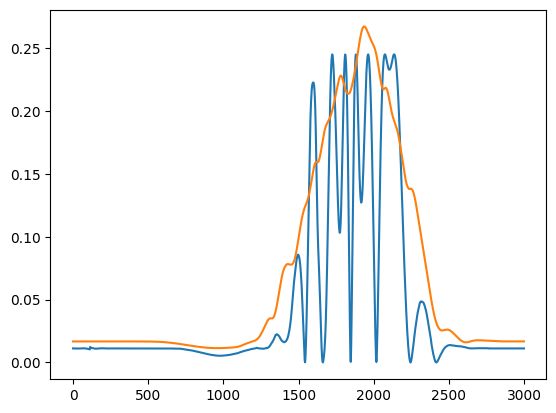

In [46]:
plt.plot(shannon[3000:6000])
plt.plot(shannon2[3000:6000])
plt.show()